In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import ttest_ind


# Загружаем данные

In [ ]:
df_b4_ab = pd.read_csv('new_dataframe.csv')
df_b4_ab = df_b4_ab.drop(axis=1, columns=['Unnamed: 0'])
df_b4_ab[['app_opened',	'price_seen',	'order_made',	'ride_completed',	'user_cancelled',	'city_center_order']] \
= df_b4_ab[['app_opened',	'price_seen',	'order_made',	'ride_completed',	'user_cancelled',	'city_center_order']].astype('int')

In [ ]:
df_b4_ab.head()

,user_id,hour,os,order_class,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm
0,867689,12,iOS,business,no surge,1,1,1,1,0,0,7.982135,20,low
1,752172,5,Android,economy,no surge,1,1,1,1,0,1,2.908468,27,high
2,486559,15,Android,comfort,no surge,1,1,1,1,0,0,7.224614,21,high
3,304024,0,Android,economy,no surge,1,1,1,1,0,1,1.874349,52,low
4,139420,0,Android,business,no surge,1,1,1,1,0,0,10.704778,19,low


In [ ]:
df_b4_ab = df_b4_ab.dropna()

# Проодим анализ данных


In [ ]:
df_b4_ab_uniq_users =df_b4_ab[['user_id', 'app_opened', 'price_seen', 'order_made', 'ride_completed', 'user_cancelled']]\
.groupby('user_id', as_index=False).sum()

In [ ]:
col = df_b4_ab_uniq_users.columns

In [ ]:
name_conv = ['conv_at_price_seen', 'conv_at_order_made', 'conv_at_ride_completed']
for i in range(1, len(col) - 2):
  df_b4_ab_uniq_users[name_conv[i-1]] = df_b4_ab_uniq_users[col[i+1]] /  df_b4_ab_uniq_users[col[i]]

In [ ]:
 df_b4_ab_uniq_users.head()

,user_id,app_opened,price_seen,order_made,ride_completed,user_cancelled,conv_at_price_seen,conv_at_order_made,conv_at_ride_completed
0,100093,4,4,3,3,0,1.0,0.750000,1.00
1,100118,5,5,5,4,1,1.0,1.000000,0.80
2,100134,5,5,4,3,1,1.0,0.800000,0.75
3,100166,5,5,4,3,1,1.0,0.800000,0.75
4,100255,9,9,5,4,1,1.0,0.555556,0.80


In [ ]:
df_b4_ab_uniq_users['4agg'] = np.zeros((df_b4_ab_uniq_users.shape[0], 1))
df_full_funnel = df_b4_ab_uniq_users[['app_opened', 'price_seen', 'order_made', 'ride_completed', '4agg']]\
.groupby('4agg', as_index=False).sum() / df_b4_ab_uniq_users.shape[0]

In [ ]:
col_2 = df_full_funnel.columns
name_conv = ['conv_at_price_seen', 'conv_at_order_made', 'conv_at_ride_completed']
for i in range(1, len(col_2) - 1):
  df_full_funnel[name_conv[i-1]] =round(df_full_funnel[col_2[i+1]] /  df_full_funnel[col_2[i]] * 100,2)

## Общая воронка 


In [ ]:
data = dict(values=df_full_funnel[['conv_at_price_seen',	'conv_at_order_made',	'conv_at_ride_completed']].values.tolist()[0],
            labels=['conv_at_price_seen',	'conv_at_order_made',	'conv_at_ride_completed'])
fig = px.funnel(data, y='labels', x='values')
fig.show()

## Пытаемся найти инсайты

In [ ]:
df_os = df_b4_ab[['os', 'app_opened', 'price_seen', 'order_made', 'ride_completed', 'user_cancelled' ]].groupby('os', as_index = False).sum()

In [ ]:
df_os

,os,app_opened,price_seen,order_made,ride_completed,user_cancelled
0,Android,50049,50049,38801,31448,7353
1,iOS,41382,41382,35435,31519,3916


In [ ]:
conv_to_cancelled_android = df_os.iloc[0]['user_cancelled'] / df_os.iloc[0]['order_made'] * 100
conv_to_cancelled_ios = df_os.iloc[1]['user_cancelled'] / df_os.iloc[1]['order_made'] * 100
print('Конверсия в отмену для пользователей андроид: ', conv_to_cancelled_android, '\nКонверсия в отмену для пользователей IOS: ', conv_to_cancelled_ios)

Конверсия в отмену для пользователей андроид:  18.950542511790932 
Конверсия в отмену для пользователей IOS:  11.051220544659234


### Видно, что пользователи с андроидом отменяют чаще




Сделать скидку в 80% для пользователей с андроидом, если у них накомпилось 5 поездок без отмен. Это вменьшит количество отмен на 5 п.п.

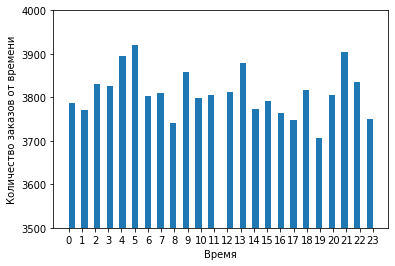

In [ ]:
plt.hist(df_b4_ab['hour'], bins=48)
plt.ylim(3500, 4000)
plt.xticks(sorted(df_b4_ab['hour'].unique()))
plt.ylabel('Количество заказов от времени')
plt.xlabel('Время')
plt.show()

### Видим небольшие просадки с 6 до 8 утра, а также с 14 до 20

Отправлять пуш уведомление с 6:00 до 8:59 с скидкой в 15% дл для всех пользователей. Это увеличит конверсию в открытие приложения на 30%, а конверсию в заказ на 10% 

In [ ]:
df_surge = df_b4_ab[['surge', 'app_opened', 'price_seen', 'order_made', 'ride_completed', 'user_cancelled' ]].groupby('surge', as_index=False).sum()

In [ ]:
df_surge


,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled
0,no surge,59788,59788,51363,43611,7752
1,surge,31643,31643,22873,19356,3517


In [ ]:
conv_to_order_nosurge = df_surge.iloc[0]['order_made'] / df_surge.iloc[0]['price_seen'] * 100
conv_to_order_surge = df_surge.iloc[1]['order_made'] / df_surge.iloc[1]['price_seen'] * 100
print('Конверсия в заказ в период no surge: ', conv_to_order_nosurge, '\nКонверсия в заказ в период surge: ', conv_to_order_surge)

Конверсия в заказ в период no surge:  85.90854352043888 
Конверсия в заказ в период surge:  72.28454950541983


### Видим, что в период surge конверсия в заказ меньше, чем в период no surge


Если добавить функционал “длительная подача”, который заключается в том, что этого клиента может взять таксист, который далеко от него, для всех клиентов в период surge, то конверсия в заказ увеличится на 10 п.п.

In [ ]:
df_users = df_b4_ab[['user_id', 'surge', 'price_seen', 'order_made']].groupby(['user_id', 'surge'], as_index = False).sum()
df_users['conv_to_order'] = df_users['order_made'] / df_users['price_seen'] * 100
df_conv_surge = df_users[[ 'surge', 'conv_to_order', 'user_id']].groupby('surge', as_index=False).agg({'conv_to_order':'sum', 'user_id': 'count'})

In [ ]:
conv_surge_no_surge = df_conv_surge['conv_to_order'][0] / df_conv_surge['user_id'][0]
conv_surge_surge = df_conv_surge['conv_to_order'][1] / df_conv_surge['user_id'][1]


In [ ]:
print('Конверсия в заказ в период no surge: ', conv_surge_no_surge, '\nКонверсия в заказ в период surge: ', conv_surge_surge)

Конверсия в заказ в период no surge:  85.98660942214717 
Конверсия в заказ в период surge:  72.35210107665112


In [ ]:
df_center = df_surge = df_b4_ab[['city_center_order', 'app_opened', 'price_seen', 'order_made', 'ride_completed', 'user_cancelled' ]].groupby('city_center_order', as_index=False).sum()

In [ ]:
df_center

,city_center_order,app_opened,price_seen,order_made,ride_completed,user_cancelled
0,0,38340,38340,29745,24113,5632
1,1,53091,53091,44491,38854,5637


In [ ]:
conv_to_order_nocenter = df_center.iloc[0]['order_made'] / df_center.iloc[0]['price_seen'] * 100
conv_to_order_center = df_center.iloc[1]['order_made'] / df_center.iloc[1]['price_seen'] * 100
print('Конверсия в заказ не из центра: ', conv_to_order_nocenter, '\nКонверсия в заказ из центра: ', conv_to_order_center)

Конверсия в заказ не из центра:  77.58215962441315 
Конверсия в заказ из центра:  83.80139760034658


### Видим, что из центра заказывют чаще, чем не из центра


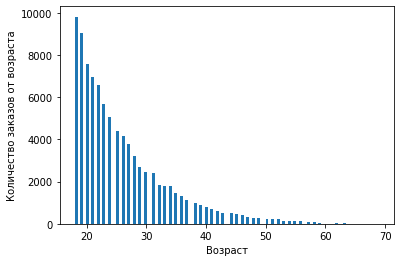

In [ ]:
plt.hist(df_b4_ab['age'], bins=110)
#plt.ylim(2000, 2500)
plt.ylabel('Количество заказов от возраста')
plt.xlabel('Возраст')
plt.show()

### Видим, что зависимость количества заказов от возраста имеет вид экспоненциального затухания


In [ ]:
df_rfm = df_b4_ab[['rfm', 'app_opened', 'price_seen', 'order_made', 'ride_completed', 'user_cancelled' ]].groupby('rfm', as_index=False).sum()

In [ ]:
df_rfm

,rfm,app_opened,price_seen,order_made,ride_completed,user_cancelled
0,high,42496,42496,34394,29360,5034
1,low,45539,45539,37077,31221,5856
2,medium,3396,3396,2765,2386,379


In [ ]:
funnel_high = []
funnel_low = []
funnel_medium = []

for i in range(1, df_rfm.shape[1]-1):
  funnel_high.append(df_rfm.iloc[0][i+1] / df_rfm.iloc[0][i] * 100)
  funnel_low.append(df_rfm.iloc[1][i+1] / df_rfm.iloc[1][i] * 100)
  funnel_medium.append(df_rfm.iloc[2][i+1] / df_rfm.iloc[2][i] * 100)

In [ ]:
funnel_high

[100.0, 80.93467620481928, 85.36372623131942, 17.145776566757494]

In [ ]:
funnel_low

[100.0, 81.4181251235205, 84.20584189659358, 18.756606130489097]

In [ ]:
funnel_medium

[100.0, 81.41931684334511, 86.29294755877034, 15.884325230511315]

### Видим, что клиенты, находящиеся в сегменте medium реже отменяют заказ

In [ ]:
df_rfm_os = df_b4_ab[['rfm', 'os', 'app_opened']].groupby(['rfm', 'os'], as_index=False).sum()

In [ ]:
df_rfm_os

,rfm,os,app_opened
0,high,Android,23209
1,high,iOS,19287
2,low,Android,24970
3,low,iOS,20569
4,medium,Android,1870
5,medium,iOS,1526


In [ ]:
df_rfm_os['procent of total'] = df_rfm_os['app_opened'] / df_rfm_os['app_opened'].sum() * 100

In [ ]:
df_rfm_os

,rfm,os,app_opened,procent of total
0,high,Android,23209,25.384169
1,high,iOS,19287,21.094596
2,low,Android,24970,27.310212
3,low,iOS,20569,22.496746
4,medium,Android,1870,2.045258
5,medium,iOS,1526,1.669018


In [ ]:
df_class = df_b4_ab[['order_class', 'app_opened', 'price_seen', 'order_made', 'ride_completed', 'user_cancelled' ]].groupby('order_class', as_index=False).sum()

In [ ]:
df_class

,order_class,app_opened,price_seen,order_made,ride_completed,user_cancelled
0,business,10795,10795,8713,7702,1011
1,comfort,38005,38005,30651,26602,4049
2,economy,42631,42631,34872,28663,6209


In [ ]:
conv_to_order_business = df_class.iloc[0]['order_made'] / df_class.iloc[0]['price_seen'] * 100
conv_to_order_comfort =  df_class.iloc[1]['order_made'] / df_class.iloc[1]['price_seen'] * 100
conv_to_order_economy =  df_class.iloc[2]['order_made'] / df_class.iloc[2]['price_seen'] * 100

conv_to_cancelled_business = df_class.iloc[0]['user_cancelled'] / df_class.iloc[0]['order_made'] * 100
conv_to_cancelled_comfort =  df_class.iloc[1]['user_cancelled'] / df_class.iloc[1]['order_made'] * 100
conv_to_cancelled_economy =  df_class.iloc[2]['user_cancelled'] / df_class.iloc[2]['order_made'] * 100

print('Конверсия в заказ у бизнесс класса: ', conv_to_order_business,
      '\nКонверсия в заказ у комфорт класса: ',  conv_to_order_comfort, 
      '\nКонверсия в заказ у эконом класса: ', conv_to_order_economy)

print('\nКонверсия в отмену у бизнесс класса: ', conv_to_cancelled_business,
      '\nКонверсия в отмену у комфорт класса: ',  conv_to_cancelled_comfort, 
      '\nКонверсия в отмену у эконом класса: ', conv_to_cancelled_economy)

Конверсия в заказ у бизнесс класса:  80.71329319129227 
Конверсия в заказ у комфорт класса:  80.64991448493619 
Конверсия в заказ у эконом класса:  81.7996293776829

Конверсия в отмену у бизнесс класса:  11.603351314128314 
Конверсия в отмену у комфорт класса:  13.210009461355257 
Конверсия в отмену у эконом класса:  17.805115852259693


### Видим, что эконом класс отменяет поездки чаще, чем остальные

Посмотрим, есть ли при этом зависимость от os

In [ ]:
df_class_os = df_b4_ab[['order_class', 'os', 'order_made', 'user_cancelled' ]]\
           .groupby(['order_class', 'os'], as_index=False).sum()

In [ ]:
df_class_os

,order_class,os,order_made,user_cancelled
0,business,Android,4567,679
1,business,iOS,4146,332
2,comfort,Android,15801,2607
3,comfort,iOS,14850,1442
4,economy,Android,18433,4067
5,economy,iOS,16439,2142


In [ ]:
conv_to_cancelled_economy_android = df_class_os.iloc[4]['user_cancelled'] / df_class_os.iloc[4]['order_made'] * 100
conv_to_cancelled_economy_iOS = df_class_os.iloc[5]['user_cancelled'] / df_class_os.iloc[5]['order_made'] * 100

print('Конверсия в отмену у эконом класса (андроид): ', conv_to_cancelled_economy_android, 
      '\nКонверсия в отмену у эконом класса (iOS): ', conv_to_cancelled_economy_iOS)

Конверсия в отмену у эконом класса (андроид):  22.06369012097868 
Конверсия в отмену у эконом класса (iOS):  13.029989658738367


Мы в целом видим, что конверсия в отмену у пользователей из эконом класса, которые пользуются андроидом выше на 2,3 п.п., чем общая конверсия в отмену у пользователей с андроидом

In [ ]:
procent_cancelled_of_total_economy_class_android = df_class_os.iloc[4]['user_cancelled'] / df_class.iloc[2]['user_cancelled'] * 100
procent_cancelled_of_total_economy_class_iOS = df_class_os.iloc[5]['user_cancelled'] / df_class.iloc[2]['user_cancelled'] * 100

print('Процент отмен в эконом классе, приходящиеся на прользователей с андроидом: ', procent_cancelled_of_total_economy_class_android,
      '\nПроцент отмен в эконом классе, приходящиеся на прользователей с iOS: ', procent_cancelled_of_total_economy_class_iOS)

Процент отмен в эконом классе, приходящиеся на прользователей с андроидом:  65.50169109357384 
Процент отмен в эконом классе, приходящиеся на прользователей с iOS:  34.49830890642615


Видим, что чаще всего в эконом классе отменяют пользоватеи с андроидом

### Если добавить функционал “длительная подача”, который заключается в том, что этого клиента может взять таксист, который далеко от него, для всех клиентов в период surge, то конверсия в заказ увеличится на 10 п.п.


## Сплит

In [ ]:
df_for_ab = df_b4_ab[df_b4_ab['surge'] == 'surge']
df_for_ab = df_for_ab.groupby('user_id', as_index=False).sum()

In [ ]:
df_for_ab = df_for_ab[['user_id', 'hour',	'app_opened',	'price_seen',	'order_made',	'ride_completed',	
                       'user_cancelled',	'city_center_order',	'distance',	'age']].groupby('user_id', as_index = False).sum()
df_for_ab['conv_to_order'] = df_for_ab['order_made'] / df_for_ab['price_seen'] * 100

In [ ]:
df_for_ab.head()


,user_id,hour,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,conv_to_order
0,100093,8,2,2,1,1,0,1,18.180559,42,50.0
1,100118,8,1,1,1,1,0,0,10.942383,26,100.0
2,100134,20,1,1,1,1,0,1,13.714453,25,100.0
3,100166,16,2,2,2,2,0,1,8.896237,36,100.0
4,100255,30,2,2,0,0,0,1,14.204168,54,0.0


In [ ]:
df_for_ab['num'] = np.random.random(df_for_ab.shape[0])

In [ ]:
df_for_ab['group'] = df_for_ab['num'].apply(lambda x:'A' if x <= 0.5 else 'B')


In [ ]:
df_for_ab.head()

,user_id,hour,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,conv_to_order,num,group
0,100093,8,2,2,1,1,0,1,18.180559,42,50.0,0.135348,A
1,100118,8,1,1,1,1,0,0,10.942383,26,100.0,0.517927,B
2,100134,20,1,1,1,1,0,1,13.714453,25,100.0,0.473699,A
3,100166,16,2,2,2,2,0,1,8.896237,36,100.0,0.954783,B
4,100255,30,2,2,0,0,0,1,14.204168,54,0.0,0.831474,B


In [ ]:
p_diff = []

for i in range(0, 10000):
  df_for_ab_sample_A = df_for_ab[df_for_ab['group'] == 'A']['conv_to_order'].sample(frac=1, replace=True).mean()
  df_for_ab_sample_B = df_for_ab[df_for_ab['group'] == 'B']['conv_to_order'].sample(frac=1, replace=True).mean()
  p_diff.append(df_for_ab_sample_A - df_for_ab_sample_B)

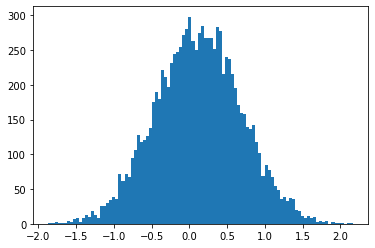

In [ ]:
plt.hist(p_diff, bins=100)
plt.show()

In [ ]:
p_diff_df = pd.DataFrame(p_diff)
p_diff_df.columns = ['mean_of_metric']

In [ ]:
alpha = 0.05

In [ ]:
A = p_diff_df['mean_of_metric'].quantile(alpha/2)
B = p_diff_df['mean_of_metric'].quantile(1 - alpha/2)

In [ ]:
print('Границы доверительного интервала: ', A, B)

Границы доверительного интервала:  -0.9814360498649172 1.239055622947804


Ноль попадает в интервал, следовательно, принимаем нулевую гипотезу о том, что выбокри однородны

# Анализ результтов

In [ ]:
df_after_ab = pd.read_csv('post_abtest_data (1).csv')

In [ ]:
df_after_ab

,user_id,date,app_opened,group,price_seen,order_made,surge,os,user_cancelled,city_center_order,groups
0,867689,2020-05-28,1,Control,1,1,no surge,Android,0.0,1.0,Control
1,867689,2020-05-29,1,Control,1,0,surge,iOS,NaN,NaN,Control
2,867689,2020-05-25,1,Control,1,1,surge,Android,0.0,0.0,Control
3,752172,2020-05-29,1,Control,1,1,surge,Android,0.0,1.0,Control
4,752172,2020-05-28,1,Control,1,1,no surge,iOS,0.0,0.0,Control
...,...,...,...,...,...,...,...,...,...,...,...
101495,777065,2020-05-25,1,Control,1,0,no surge,Android,NaN,NaN,Control
101496,340213,2020-05-28,1,Control,1,1,no surge,iOS,0.0,1.0,Control
101497,352605,2020-05-26,1,Test,1,1,no surge,Android,0.0,1.0,Test
101498,216082,2020-05-26,1,Control,1,0,surge,Android,NaN,NaN,Control


In [ ]:
df_after_ab_surge = df_after_ab[(df_after_ab['surge'] == 'surge') & (df_after_ab['price_seen'] > 0)]
df_after_ab_surge = df_after_ab_surge[['user_id',	'date',	'price_seen',	'order_made', 'groups']]

In [ ]:
date = df_after_ab_surge['date'].unique()

In [ ]:
list_of_p_value = []
df_prom = df_after_ab_surge[df_after_ab_surge['date'] == date[0]]
df_prom = df_prom.groupby(['user_id','groups'], as_index=False).sum()
df_prom['conv'] = df_prom['order_made'] / df_prom['price_seen']
list_of_p_value.append(ttest_ind(
        df_prom[df_prom['groups'] == 'Control'].conv, 
        df_prom[df_prom['groups'] == 'Test'   ].conv
    )[1])
for i in date:
  if i != date[0]:
    df_special_date = df_after_ab_surge[df_after_ab_surge['date'] == i]
    df_special_date = df_special_date.groupby(['user_id','groups'], as_index=False).sum()
    df_special_date['conv'] = df_special_date['order_made'] / df_special_date['price_seen']
    df_prom = pd.concat([df_prom, df_special_date])
    list_of_p_value.append(ttest_ind(
        df_prom[df_prom['groups'] == 'Control'].conv, 
        df_prom[df_prom['groups'] == 'Test'   ].conv
    )[1])

In [ ]:
alpha = 0.05

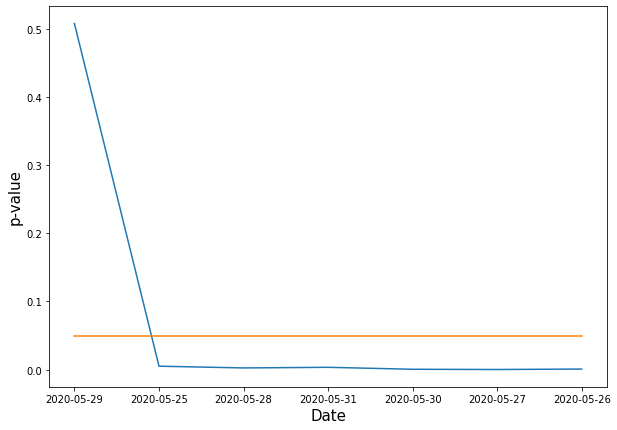

In [ ]:
fig, axs = plt.subplots(figsize=(10,7))
axs.plot(date, list_of_p_value, date, [alpha]*7)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel("Date", {"fontsize": 15}) # 'fontsize' задает размер текста
plt.ylabel("p-value", {"fontsize": 15})
plt.show()